### Overview

In this project, I want to generate star trek scripts. Previously I tried to train locally to predict the next word, but ran into hardware issues. Now I am going to try instruction fine-tuning and Parameter Efficient Fine-tuning. I also think it might help to try to generate sequences (lines of dialog) rather than single word, since I can transfer that skill from other transformer models.

This time, let's try to use the FLAN-T5 model as our tokenizer and base model. We're now using Pytorch instead of tensorflow because I can adapt code to easily load the HuggingFace FLAN-T5 model.

In [92]:
import json
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd

# from transformers import TFGPT2LMHeadModel, TFGPT2Model, GPT2Tokenizer, GPT2Config
# from transformers import DistilBertTokenizer, TFDistilBertModel
import re
from sklearn.model_selection import train_test_split
from random import randint
import matplotlib.pyplot as plt

import string
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)

2.12.0


In [24]:
f = open("../data/StarTrek_scripts/all_scripts_raw.json")
json_file = json.load(f)
f.close()
#start with TOS: might be more manageable
TOS_scripts=json_file['TOS']
print(TOS_scripts['episode 3'][:2000])







The Star Trek Transcripts - Where No Man Has Gone Before


Where
No Man Has Gone Before
Stardate:
1312.4
Original Airdate: 22 Sep, 1966







 
Captain's log, Star date 1312.4. The impossible has happened. From
directly ahead, we're picking up a recorded distress signal, the call
letters of a vessel which has been missing for over two centuries. Did
another Earth ship once probe out of the galaxy as we intend to do?
What happened to it out there? Is this some warning they've left
behind?

[Briefing room]

SPOCK: Your move, Captain. 
KIRK: We should have intercepted by now. The Bridge said they'd call. 
SPOCK: I'll have you checkmated your next move. 
KIRK: Have I ever mentioned you play a very irritating game of chess,
Mister Spock? 
SPOCK: Irritating? Ah, yes. One of your Earth emotions. 
KIRK: Certain you don't know what irritation is? 
SPOCK: The fact one of my ancestors married a human female 
KIRK: Terrible having bad blood like that. 
KELSO [on monitor] Bridge to briefing 

### General plan

I want to generate a star trek script. The input is one line of dialog (or stage direction), the output is the next line. Since we're trying to instruction-tune FLAN-T5, I don't want to introduce custom tokens. Hopefully it figures out what is dialog and what is stage direction.

To make this, that means I need to:
- parse the scripts, separating by line

- Remove episode title at beginning and copyright stuff at the end.
    
- Create segments of line, next line pairs

- Embed the wordings

- Split train/test data

- Create model and train
    


In [114]:
#functions to remove metadata and split script

def remove_metadata(script):
    # Find the position of the 17th newline character
    start_pos = -1
    for _ in range(17):
        start_pos = script.find('\n', start_pos + 1)
        
    # Slice the string from the character after the next newline
    if start_pos != -1:
        script = script[start_pos + 1:]
    
    # Find the position of "<Back"
    pos = script.find("<Back")

    # If found, cut off everything past that point
    if pos != -1:
        script = script[:pos]
    return script

def parse_lines(script_string):
    #replace \r\n with spaces
    # script_string=script_string.replace("\r\n", " ")
    
    # Regular expression with positive lookahead to match "\n[A-Z]+:"
    pattern = r"(?=\n[A-Z]+:|\[[^\]]+\])"
    
    # Use re.split to break the string at each match
    split_script = re.split(pattern, script_string)
    parsed_script = [clean_single_line(line) for line in split_script]
    return parsed_script

def clean_single_line(line):
    line=line.replace("\r\n", " ")
    line=line.replace("\r", "")
    line=line.replace("\n", "")
    return line.strip()

def recombine_lines(script_lines):
    return "\n".join(script_lines)

i=1
parsed_script=parse_lines(remove_metadata(TOS_scripts['episode '+str(i)]))
for j in range(5):
    print(parsed_script[j])
    print('\n')
# print(recombine_lines(parsed_script))

    

Captain's log, Stardate 1513.1. Our position, orbiting planet M-113. On board the Enterprise, Mister Spock temporarily in command. On the planet the ruins of an ancient and long-dead civilisation. Ship's surgeon McCoy and myself are now beaming down to the planet's surface. Our mission, routine medical examination of archaeologist Robert Crater and his wife Nancy. Routine but for the fact that Nancy Crater is that one woman in Doctor McCoy's past.


[Planet surface outside building]


KIRK: Shall we pick some flowers, Doctor? When a man visits an old girlfriend she usually expects something like that.


MCCOY: Is that how you get girls to like you, by bribing them? There doesn't seem to be anybody around, does there.


KIRK: They'll be along. You rushed us down ten minutes early. (enter building)




In [93]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [126]:
j=0
line_1in = parsed_script[j]
line_2in = parsed_script[j+1]
line_3in = parsed_script[j+2]
line_4in = parsed_script[j+3]
next_line = parsed_script[j+4]

prompt = f"""
Predict the next line of this Star Trek script:

{line_1in}

{line_2in}

{line_3in}

{line_4in}

"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'ACTUAL NEXT LINE:\n{next_line}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Predict the next line of this Star Trek script:

Captain's log, Stardate 1513.1. Our position, orbiting planet M-113. On board the Enterprise, Mister Spock temporarily in command. On the planet the ruins of an ancient and long-dead civilisation. Ship's surgeon McCoy and myself are now beaming down to the planet's surface. Our mission, routine medical examination of archaeologist Robert Crater and his wife Nancy. Routine but for the fact that Nancy Crater is that one woman in Doctor McCoy's past.

[Planet surface outside building]

KIRK: Shall we pick some flowers, Doctor? When a man visits an old girlfriend she usually expects something like that.

MCCOY: Is that how you get girls to like you, by bribing them? There doesn't seem to be anybody around, does there.


---------------------------------------------------------------------------------------------------
ACTUAL NEX

#### Some thoughts on training and test
I want to tokenize all the scripts and make chunks of 80 tokens used to predict the next word. But if I take words 0:8, then 1:81, and so on, the data will be highly correlated. This means I can't just randomly take 20\% of these chunks out for test data. Instead, I'll split at the episode level. I have 80 episodes- I'll arbitrarily assign 16 episodes to test data, and set those scripts aside.

### Process scripts and chunk into training and test sets
I initially ran this with a standard layout of 10% validation, 20% test data, but I found that I wasn't really using the test data any different than the validation data. The real test is at the end when I generate something new. Furthermore, I compared two cases: one where it seemed to have its best validation loss (I only trained for ~50 epochs due to hardware limitations), and one where it had the best train loss, but was overfit. The overfit result actually seems to produce more realistic scripts in the final product, so I don't think overfitting as as dangerous for this application as it would be for others. For these reasons, I'm now going to try removing the test set and keeping only 5% in validation, and increasing the size of the training sample as much as I can


In [6]:
scripts=[TOS_scripts['episode '+str(i)] for i in range(len(TOS_scripts))]
random_state=42
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# train_scripts, test_scripts = train_test_split(scripts, test_size=0.2, random_state=random_state)
# train_scripts, val_scripts = train_test_split(train_scripts, test_size=1/8, random_state=random_state)  # 10% of 80% = 1/8
train_scripts, val_scripts = train_test_split(scripts, test_size=0.05, random_state=random_state)  # 10% of 80% = 1/8
# Initialize a set to hold unique new tokens
unique_new_tokens = set()

# Preprocess the scripts and collect new tokens
processed_scripts = []
for script in train_scripts:
    processed_text, new_tokens = preprocess_script(script)
    processed_scripts.append(processed_text)
    unique_new_tokens.update(new_tokens)
new_tokens=list(unique_new_tokens)

for token in ["<loc>", "<char>", "<sd>", "<end>", "<pad>"]:
    new_tokens.append(token)
add_tokens = [token for token in new_tokens if token not in tokenizer.get_vocab()]
# Add unique new tokens to the tokenizer
tokenizer.add_tokens(list(add_tokens))
print('vocab size: ',len(tokenizer))

# # Tokenize all the processed scripts
# tokenizer.pad_token = "<PAD>"
tokenized_scripts = [tokenizer.tokenize(script) for script in processed_scripts]

maxlen = 80  # Max sequence size
def create_chunks(tokenized_scripts, chunk_size=maxlen+1, stride=1,padded_chunks_per_script=10000):
    #create overlapping chunks of 80 tokens to predict the next word
    X=[]
    y=[]
    for tokenized_script in tokenized_scripts:
        for i in range(0, len(tokenized_script) - chunk_size + 1, stride):
            chunk = tokenized_script[i:i + chunk_size]
            X.append(chunk[:-1])
            y.append([chunk[-1]])
        #The user might not provide full 80 words, so lets augment using random padded sequences.
        for _ in range(padded_chunks_per_script):
            start_index = randint(0, len(tokenized_script) - 2) # -2 to leave room for at least one token
            random_length = randint(2, chunk_size - 1) # Choose a random length less than chunk_size
            end_index = start_index + random_length
            # Select the random chunk
            chunk = tokenized_script[start_index:end_index]
            # print(chunk)
            y.append([chunk[-1]])
            # print([chunk[-1]])
            X_chunk=chunk[:-1]
            # Pad the chunk to the desired length
            padding_needed = chunk_size - len(chunk)
            # pad_token = tokenizer.pad_token_id # or whatever your padding token is
            pads= ["<pad>"] * padding_needed
            X_chunk= pads + X_chunk
            # print(X_chunk)
            X.append(X_chunk)
    X =np.array([tokenizer.convert_tokens_to_ids(x) for x in X])
    y =np.array([tokenizer.convert_tokens_to_ids(_y) for _y in y])
    return X,y

train_X, train_y=create_chunks(tokenized_scripts)

processed_val_scripts=[]
for script in val_scripts:
    processed_text, new_tokens = preprocess_script(script)
    processed_val_scripts.append(processed_text)
tokenized_val_scripts = [tokenizer.tokenize(script) for script in processed_val_scripts]
val_X, val_y=create_chunks(tokenized_val_scripts)

# processed_test_scripts=[]
# for script in test_scripts:
#     processed_text, new_tokens = preprocess_script(script)
#     processed_test_scripts.append(processed_text)
# tokenized_test_scripts = [tokenizer.tokenize(script) for script in processed_test_scripts]
# test_X, test_y=create_chunks(tokenized_test_scripts
print('train shape: ',np.shape(train_X))
print('val shape: ',np.shape(val_X))
# print('test shape: ',np.shape(test_X))



vocab size:  30735
train shape:  (1368560, 80)
val shape:  (71059, 80)


In [7]:
example_idx=0
example=val_X[example_idx]
tokens = tokenizer.convert_ids_to_tokens(example)
print(tokens)
print(' '.join(tokens).replace(' ##', '')) # Joining tokens and handling subtokens
print(tokenizer.convert_ids_to_tokens(val_y[example_idx]))

['<loc>', 'corridor', '<loc>', '<sd>', 'kirk', 'has', 'just', 'climbed', 'up', 'a', 'ladder', 'to', 'this', 'deck', 'when', 'mccoy', 'exits', 'the', 'turbo', '##lift', '.', '<sd>', '<char>', 'mccoy', ':', 'oh', ',', 'captain', '.', 'got', 'a', 'minute', '?', '<char>', 'kirk', ':', 'a', 'minute', '.', '<char>', 'mccoy', ':', 'it', "'", 's', 'spock', '.', 'have', 'you', 'noticed', 'anything', 'strange', 'about', 'him', '?', '<char>', 'kirk', ':', 'no', ',', 'nothing', 'in', 'particular', '.', 'why', '?', '<char>', 'mccoy', ':', 'well', ',', 'it', "'", 's', 'nothing', 'i', 'can', 'pin', '##point', 'without']
<loc> corridor <loc> <sd> kirk has just climbed up a ladder to this deck when mccoy exits the turbolift . <sd> <char> mccoy : oh , captain . got a minute ? <char> kirk : a minute . <char> mccoy : it ' s spock . have you noticed anything strange about him ? <char> kirk : no , nothing in particular . why ? <char> mccoy : well , it ' s nothing i can pinpoint without
['an']


### Define miniature transformer model

I'm adapting the small transformer from https://keras.io/examples/generative/text_generation_with_miniature_gpt/
seeing as GPT is way to big for me to train with my hardware.

It looks like a big part of my parameters comes from word embeddings and the dense layer at the end, so I might want to try to reduce my vocabulary. I could use TextVectorization instead of BERT's tokenizer.

In [9]:
#build a miniature transformer model based on https://keras.io/examples/generative/text_generation_with_miniature_gpt/
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
vocab_size = len(tokenizer)  # Only consider the top 20k words
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    # x = layers.Dense(vocab_size)(x)
    x = layers.GlobalAveragePooling1D()(x) #added this layer to change the architecture to predict only 1 word
    outputs = layers.Dense(vocab_size)(x) #logits of single predicted word
    model = keras.Model(inputs=inputs, outputs=outputs)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=loss_fn,
    )  # No loss and optimization based on word embeddings from transformer block
    return model

def save_history(history, filename):
    with open(filename, 'w') as f:
        json.dump(history.history, f)

def load_history(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [22]:

    
for checkpoint_load_idx in range(3,5):
    # Load previous history if exists
    try:
        history_data = load_history("StarTrek_oneword_history.json")
    except:
        history_data = {'loss': [], 'val_loss': []}

    # Load model if exists
    model = create_model()  # Your function to create a model
    model.summary()
    try:
        model.load_weights("StarTrek_oneword_model_checkpoint"+str(checkpoint_load_idx)+".h5")
        checkpoint_cb = ModelCheckpoint("StarTrek_oneword_model_checkpoint"+str(checkpoint_load_idx+1)+".h5",
                                        save_best_only=True, monitor='loss')
        print('loading checkpoint: ', "StarTrek_oneword_model_checkpoint"+str(checkpoint_load_idx)+".h5" )
    except:

        checkpoint_cb = ModelCheckpoint("StarTrek_oneword_model_checkpoint"+str(checkpoint_load_idx)+".h5",
                                        save_best_only=True, monitor='loss')
    # Fit the model
    history = model.fit(
        train_X, train_y, 
        validation_data=(val_X, val_y), 
        epochs=10, 
        callbacks=[checkpoint_cb]
    )

    # Update history
    for key in history.history:
        history_data[key].extend(history.history[key])

    # Save history
    save_history(history, "StarTrek_oneword_history.json")





# with open('StarTrek_oneword_history.json', 'r') as f:
#     loaded_history = json.load(f)

# for loop_i in range(10):
#     checkpoint_filepath = 'StarTrek_oneword_model_checkpoint'+str(loop_i+1)+'.h5'

#     model_checkpoint_callback = ModelCheckpoint(
#         filepath=checkpoint_filepath,
#         save_weights_only=True,
#         monitor='loss',
#         mode='min',
#         save_best_only=True)
#     model.load_weights('StarTrek_oneword_model_checkpoint'+str(loop_i)+'.h5')
#     history=model.fit(train_X, 
#                   train_y, 
#                   validation_data=(val_X, val_y), 
#                   callbacks=[model_checkpoint_callback], 
#                   verbose=1, 
#                   epochs=10)
#     hist_dict=history.history
#     for key in hist_dict.keys():
#         loaded_history[key].extend(hist_dict[key])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80)]              0         
                                                                 
 token_and_position_embeddi  (None, 80, 128)           3944320   
 ng_2 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_2 (Trans  (None, 80, 128)           593920    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 30735)             3964

2023-08-31 10:13:42.855700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42768/42768 [==============================] - ETA: 0s - loss: 3.5357

2023-08-31 12:10:27.964159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42768/42768 [==============================] - 7136s 167ms/step - loss: 3.5357 - val_loss: 5.0290
Epoch 2/10


/Users/matt/miniconda3/envs/tf_metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42768/42768 [==============================] - 6767s 158ms/step - loss: 3.3361 - val_loss: 5.0352
Epoch 3/10
42768/42768 [==============================] - 6531s 153ms/step - loss: 3.2917 - val_loss: 5.0314
Epoch 4/10
42768/42768 [==============================] - 6582s 154ms/step - loss: 3.2621 - val_loss: 5.1144
Epoch 5/10
42768/42768 [==============================] - 6594s 154ms/step - loss: 3.2429 - val_loss: 5.0685
Epoch 6/10
42768/42768 [==============================] - 6685s 156ms/step - loss: 3.2313 - val_loss: 5.1326
Epoch 7/10
42768/42768 [==============================] - 7003s 164ms/step - loss: 3.2123 - val_loss: 5.1168
Epoch 8/10
42768/42768 [==============================] - 6953s 163ms/step - loss: 3.1945 - val_loss: 5.1294
Epoch 9/10
42768/42768 [==============================] - 6761s 158ms/step - loss: 3.1821 - val_loss: 5.1395
Epoch 10/10
42768/42768 [==============================] - 6718s 157ms/step - loss: 3.1715 - val_loss: 5.1633
Model: "model_3"
____________

2023-09-01 05:02:34.291500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42768/42768 [==============================] - ETA: 0s - loss: 3.2619

2023-09-01 06:50:12.853128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42768/42768 [==============================] - 6587s 154ms/step - loss: 3.2619 - val_loss: 5.1767
Epoch 2/10
42768/42768 [==============================] - 6703s 157ms/step - loss: 3.1600 - val_loss: 5.1758
Epoch 3/10
42768/42768 [==============================] - 6979s 163ms/step - loss: 3.1422 - val_loss: 5.1918
Epoch 4/10
42768/42768 [==============================] - 7531s 176ms/step - loss: 3.1342 - val_loss: 5.2722
Epoch 5/10
42768/42768 [==============================] - 7540s 176ms/step - loss: 3.1146 - val_loss: 5.2318
Epoch 6/10
42768/42768 [==============================] - 6800s 159ms/step - loss: 3.1053 - val_loss: 5.2011
Epoch 7/10
42768/42768 [==============================] - 7480s 175ms/step - loss: 3.0976 - val_loss: 5.3004
Epoch 8/10
42768/42768 [==============================] - 7555s 177ms/step - loss: 3.0975 - val_loss: 5.2758
Epoch 9/10
42768/42768 [==============================] - 7585s 177ms/step - loss: 3.0878 - val_loss: 5.2959
Epoch 10/10
42768/42768 [=====

In [ ]:
# model = create_model()
# model.load_weights('StarTrek_oneword_model_checkpoint8.h5')
# loss = model.evaluate(test_X, test_y)

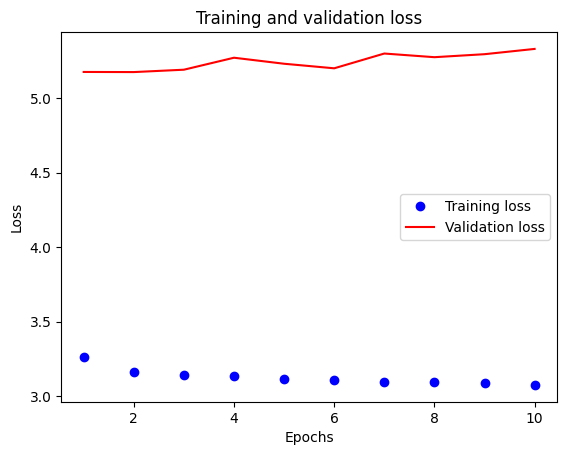

In [23]:
#plot history
# print(history.history)
loaded_history=load_history("StarTrek_oneword_history.json")
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [24]:
def convert_input_to_token_idx(string):
    processed_string=preprocess_script(string)[0][:-5]
    input_tokens= tokenizer.tokenize(processed_string)
    input_tokens=tokenizer.convert_tokens_to_ids(input_tokens)
    padding_needed = 80 - len(input_tokens)
    pad_token = tokenizer.pad_token_id # or whatever your padding token is
    input_tokens += [pad_token] * padding_needed
    return np.array(input_tokens)

def convert_token_idx_to_string(tokens):
    string_array=tokenizer.convert_ids_to_tokens(tokens)
    string_array=[string for string in string_array if string != "[PAD]"]
    text = ' '.join(string_array).replace(' ##', '').replace('[PAD]', '')
    return text

model = create_model()  # Your function to create a model
model.summary()
model.load_weights("StarTrek_oneword_model_checkpoint3.h5")

input_string="Captain's log, star"
# input_string="\nKIRK: Set ship status condition"
input_tokens=convert_input_to_token_idx(input_string)
input_tokens=val_X[17]
print(input_tokens)
print(tokenizer.convert_ids_to_tokens(train_y[8]))
# print(input_tokens)
# print(type(train_X[0]))
# print(np.shape(train_X[0]))
print(tokenizer.convert_ids_to_tokens(input_tokens))
print('input = \n',convert_token_idx_to_string(input_tokens),'\n')
generated_token=np.argmax(model.predict(np.expand_dims(input_tokens,axis=0)),axis=-1)
next_word=convert_token_idx_to_string(generated_token)
print('\n')
print('generated = \n', convert_token_idx_to_string(input_tokens)+' '+next_word)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 80)]              0         
                                                                 
 token_and_position_embeddi  (None, 80, 128)           3944320   
 ng_4 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_4 (Trans  (None, 80, 128)           593920    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_4  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 30735)             3964

2023-09-02 09:03:57.865371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 436ms/step


generated = 
 the turbolift . <sd> <char> mccoy : oh , captain . got a minute ? <char> kirk : a minute . <char> mccoy : it ' s spock . have you noticed anything strange about him ? <char> kirk : no , nothing in particular . why ? <char> mccoy : well , it ' s nothing i can pinpoint without an examination , but he ' s become increasingly restive . if he were not a little


In [32]:
#generate a longer script

input_tokens=val_X[2000]
script=list(input_tokens)
for i in range(200):
    generated_token=list(np.argmax(model.predict(np.expand_dims(input_tokens,axis=0),verbose=0),axis=-1))
    script.append(generated_token[0])
    input_tokens=script[-80:]
script=convert_token_idx_to_string(script)
script = script.replace('<char>', '\n')
print(script)


mccoy has given me his medical evaluation of your condition . he says you ' re going to die unless something is done . what ? is it something only your planet can do for you ? spock ! you ' ve been called the best first officer in the fleet . that ' s an enormous asset to me . if i have to lose that first officer , i want to know why . 
 spock : it ' s not a vulcan . 
 kirk : i ' m sure that ' s what i am going to be a very good . i ' m sure that ' s what i ' ve got to say that thing ? 
 kirk : yes , i know what you ' re going to do . 
 mccoy : i ' m sure that ' s what i ' ve got a few hours . 
 kirk : i ' m afraid that ' s what i want to know . 
 kirk : i ' m afraid that ' s what you comm n . 
 kirk : i ' m afraid you ' ll be a very well , captain . i ' m afraid of you . i ' m afraid of that , i ' m afraid of you . i ' m afraid you ' ll be a very well , captain . i ' m not sure you ' ll have to take you to the enterprise . 
 kirk : i ' ll be right to be a very good . i ' ll take you t

Not as humanlike as I hoped. I think transformers need a lot more data to sound humanlike. Maybe if I trained starting from GPT, but my hardware limits me. 

In [ ]:
# Experimenting using TextVectorization tokenization instead of DistilBERT
# scripts=[TOS_scripts['episode '+str(i)] for i in range(len(TOS_scripts))]
# random_state=42
# train_scripts, test_scripts = train_test_split(scripts, test_size=0.2, random_state=random_state)
# train_scripts, val_scripts = train_test_split(train_scripts, test_size=1/8, random_state=random_state)  # 10% of 80% = 1/8

# processed_train_scripts = [preprocess_script(script)[0] for script in train_scripts]
# big_string = ' '.join(processed_train_scripts)

# # Convert to a TensorFlow Dataset
# dataset = tf.data.Dataset.from_tensor_slices([big_string])
# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     cleaned_string = tf.strings.regex_replace(stripped_html, "\xa0", " ")  # Replacing non-breaking space with regular space
#     # Exclude < and > from the punctuation string
#     punctuation_without_angle_brackets = string.punctuation.replace("<", "").replace(">", "")
#     return tf.strings.regex_replace(cleaned_string, f"([{punctuation_without_angle_brackets}])", r" \1")

# # Create a vectorization layer and adapt it to the text
# vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=vocab_size - 1,
#     output_mode="int",
#     # output_sequence_length=maxlen + 1,
# )
# with tf.device('/CPU:0'):
#     # Your code here (e.g., adapting the vectorize layer)
#     vectorize_layer.adapt(dataset) #for some reason this won't work on my GPU
# vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

# #create chunks of training, val, and test data
# window_size = 81
# step_size = 3  # This defines the overlap; change as needed
# padded_chunks_per_script=0 #not yet implemented

# # Tokenize all the processed scripts
# processed_train_scripts_tensor = tf.constant(processed_train_scripts)
# vectorized_train_scripts = vectorize_layer(processed_train_scripts_tensor)
# def create_chunks(tokenized_scripts, window_size=window_size, step_size=step_size, padded_chunks_per_script=padded_chunks_per_script):
#     chunks = []
#     for script in tokenized_scripts:
#         for i in range(0, len(script) - window_size + 1, step_size):
#             chunk = script[i:i + window_size]
#             chunks.append(chunk)
#     return chunks

# train_chunks=create_chunks(vectorized_train_scripts)
# train_X=np.array([chunk[:-1] for chunk in train_chunks])
# train_y=np.array([chunk[1:] for chunk in train_chunks])

# #do the same for validation and test data
# processed_val_scripts = [preprocess_script(script)[0] for script in val_scripts]
# processed_val_scripts_tensor = tf.constant(processed_val_scripts)
# vectorized_val_scripts = vectorize_layer(processed_val_scripts_tensor)
# val_chunks=create_chunks(vectorized_val_scripts)
# val_X=np.array([chunk[:-1] for chunk in val_chunks])
# val_y=np.array([chunk[1:] for chunk in val_chunks])


# processed_test_scripts = [preprocess_script(script)[0] for script in test_scripts]
# processed_test_scripts_tensor = tf.constant(processed_test_scripts)
# vectorized_test_scripts = vectorize_layer(processed_test_scripts_tensor)
# test_chunks=create_chunks(vectorized_test_scripts)
# test_X=np.array([chunk[:-1] for chunk in test_chunks])
# test_y=np.array([chunk[1:] for chunk in test_chunks])

In [ ]:
# #demonstrate how the vectorize layer works and how the x y vectors work
# print(np.shape(train_X))
# print(np.shape(val_X))
# print(np.shape(test_X))
# print(train_X[-1]) #batching caused shorter scripts to be filled with zeros. Maybe go back to the loop mehtod
# print([vocab[idx] for idx in val_X[12]])
# print([vocab[idx] for idx in val_y[12]])
# # print(vocab[:20])

In [ ]:

# #use GPT-2 model. We'll need to train from here to learn star trek vocab
# Initializing a GPT2 configuration

configuration = GPT2Config.from_pretrained('distilgpt2')
configuration.vocab_size = len(tokenizer)
# configuration.n_positions = 128 #The maximum sequence length that this model might ever be used with. 
# configuration.n_embd = 768, #768, #Dimensionality of the embeddings and hidden states.
# configuration.n_layer = 4, #12, #Number of hidden layers in the Transformer encoder.
# configuration.n_head = 4, #12, #Number of attention heads for each attention layer in the Transformer encoder.
                           
model = TFGPT2Model(configuration)
model.resize_token_embeddings(len(tokenizer))  # resizing to match new vocab size

# If you want to see the summary, you can build the model first:
model.build(input_shape=(None, 128))  # None for batch size, 128 for sequence length

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


# configuration = GPT2Config(vocab_size = len(tokenizer), 
#                            n_positions = 128, #The maximum sequence length that this model might ever be used with. 
#                            n_embd = 64, #768, #Dimensionality of the embeddings and hidden states.
#                            n_layer = 4, #12, #Number of hidden layers in the Transformer encoder.
#                            n_head = 4, #12, #Number of attention heads for each attention layer in the Transformer encoder.
#                            n_inner = None,
#                            activation_function = 'gelu_new',
#                            resid_pdrop = 0.1,
#                            embd_pdrop = 0.1,
#                            attn_pdrop = 0.1,
#                            layer_norm_epsilon = 1e-05,
#                            initializer_range = 0.02,
#                            summary_type = 'cls_index',
#                            summary_use_proj = True,
#                            summary_activation = None,
#                            summary_proj_to_labels = True,
#                            summary_first_dropout = 0.1,
#                            scale_attn_weights = True,
#                            use_cache = True,
#                            bos_token_id = 50256,
#                            eos_token_id = 50256,
#                            scale_attn_by_inverse_layer_idx = False,
#                            reorder_and_upcast_attn = False)

# # Initializing a model (with random weights) from the configuration
# model = TFGPT2LMHeadModel(configuration)
# # from tensorflow.keras.layers import Input, Dense
# # from tensorflow.keras.models import Model
# # input_layer = Input(shape=(128,), dtype='int32')
# # gpt2_output = gpt2_model(input_layer)
# # output_layer = Dense(vocab_size, activation='softmax')(gpt2_output[0][:,-1,:])

# # model = Model(inputs=input_layer, outputs=output_layer)
# # model = TFGPT2LMHeadModel.from_pretrained("gpt2")
# model.resize_token_embeddings(len(tokenizer))  # resizing to match new vocab size
# # print(len(tokenizer))

# # #use DistilBERT model. We'll need to train from here to learn star trek vocab
# # model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# # model.resize_token_embeddings(len(tokenizer))  # resizing to match new vocab size
# print(len(tokenizer))

In [ ]:
# #training
# # Train only the embedding layer

# # Freeze all layers within the transformer
# for layer in model.transformer.h:
#     layer.trainable = False
# # Unfreeze the embedding layer (wte)
# model.transformer.wte.trainable = True
# # Freeze all layers first
# # for layer in model.layers:
# #     layer.trainable = False

# # # Unfreeze the embedding layer
# # model.layers[0].embeddings.trainable = True

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# model.summary()
# history = model.fit(x=train_X, y=train_y, epochs=10, batch_size=32, validation_data=(val_X, val_y))

# # # Save the weights
# model.save_weights('StarTrek_weights.h5')

# # # Unfreeze more layers (optional)
# # for layer in model.layers[:n]:  # Unfreeze the first n layers
# #     layer.trainable = True
# # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', lr=0.0001) # Smaller learning rate
# # model.fit(training_data)

# # # Unfreeze all layers (optional)
# # for layer in model.layers:
# #     layer.trainable = True
# # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', lr=0.00001) # Even smaller learning rate
# # model.fit(training_data)

# # # Save the final model
# # model.save('final_model.h5')


In [ ]:
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# plt.plot(train_loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()